#**LABORATORIO 03 - REDES CONVOLUCIONALES**

##Nombre: Gonzales Suyo Franz Reinaldo

##C.U. 111-500

##Link GitHub: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-03_CNN

##CONTEXTO DEL LABORATORIO

Elaborar:

1. Con el dataset elaborado, construir una red neuronal convolucional que permita identificar (clasificar) las diferentes plantas medicinales que se puedan obtener a partir de una imagen fotografica, es decir se deben utilizar el dataset para entrenar y validar la efectividad del modelo desarrollado, se debe aplicar las tenicas que considere necesarias de las revisadas para lograr obtener los mejores parametros para el modelo. Las pruebas de la efectividad se realizaran con imagenes que se capturaran con una camara fotográfica.


2. Realizar lo solicitado en el punto 1, pero utilizando un modelo preentrenado y aplicando tecnicas de transfer learning y fine tunning.

Se debe elaborar un informe en relacion a los resultados que se obtengan en cada parte del trabajo.

El cuadernillo a presentar solo debe tener informacion que el estudiante considere necesaria.

Se debe subir el cuadernillo a ecampus y a su repositorio, para lo cual se debe incluir la dirección del mismo.

Se recomienda realizar un trabajo responsable y detallado, por cuanto este trabajo tiene una calificación especial y es parte del examen del primer parcial, por lo cual codigos que se identifiquen copia o no sean adecuadamente defendidos seran considerados como copia o no validos.

In [ ]:
# DESCARGAMOS LAS LIBRERIAS
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


##1. Preparación del Dataset

Nuestro dataset es sobre 5 tipos de plantas medicinales, que son mas de 75000 imagenes, en este post aplicaremos todos las tecnicas que se aplican para contruir un modelo de red convolucional.

Nuestro dataset cuenta con 5 tipos de clases: Acelga, Cebolla, Espinaca, Lechuga y Toronjil.


In [ ]:
""""
Leemos el Dataset para trabajar en base de ello, ademas aplicamos las buenas prácticas
como las transformaciones de las imagenes y redimencionamiento a un 50x50 píxeles.
"""

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])

# Cargar los datasets de entrenamiento y prueba
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 15000


In [ ]:
# Aplicamos el objeto de dataset Dataloader para cargar los datos en batches de 64 imágenes.
trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
from torch.utils.data import Subset

# Definir los índices para las dos partes del dataset
indice1 = list(range(30000))  # Los primeros 30,000 ejemplos
indices2 = list(range(30000, 60000))  # Los siguientes 30,000 ejemplos

# Crear los subconjuntos usando Subset
train_data1 = Subset(train_data, indice1)
train_data2 = Subset(train_data, indices2)

# Crear los subconjuntos usando Subset
test_data1 = Subset(test_data, indice1)
test_data2 = Subset(test_data, indices2)

# Verificar los tamaños de los nuevos conjuntos de datos
print("Tamaño del primer conjunto de entrenamiento:", len(train_data1))
print("Tamaño del segundo conjunto de entrenamiento:", len(train_data2))

print("Tamaño del primer conjunto de prueba:", len(test_data1))
print("Tamaño del segundo conjunto de prueba:", len(test_data2))


Tamaño del primer conjunto de entrenamiento: 30000
Tamaño del segundo conjunto de entrenamiento: 30000
Tamaño del primer conjunto de prueba: 30000
Tamaño del segundo conjunto de prueba: 30000


In [ ]:
train_loader1 = DataLoader(train_data1, batch_size=64, shuffle=True)
test_loader1 = DataLoader(test_data1, batch_size=64, shuffle=True)

In [ ]:
# Crear DataLoaders para ambos subconjuntos
train_loader2 = DataLoader(train_data2, batch_size=64, shuffle=True)
test_test2 = DataLoader(test_data2, batch_size=64, shuffle=True)

Mostamos alguans imagenes que se capturan a partir de los datos, cada imagen se visualiza com sus respectivas clases.

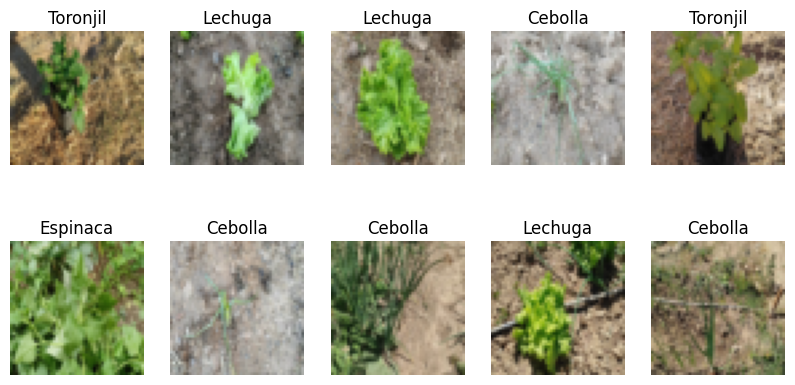

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

##2. Diseño de la Red Convolucional

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()  # Inicializar la clase base
        # Definir la primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        # Definir una capa de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Definir la segunda capa convolucional
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        # Definir la tercera capa convolucional
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)

        self._to_linear = None
        self.convs(torch.randn(1, 3, 50, 50))  # Pasar un tensor de ejemplo para calcular _to_linear

        # Definición de las capas totalmente conectadas (fully connected layers)

        # Definir la primera capa totalmente conectada (fully connected)
        self.fc1 = nn.Linear(self._to_linear, 512)
        # Definir la segunda capa totalmente conectada
        self.fc2 = nn.Linear(512, 128)
        # Definir la capa de salida con 5 neuronas (una para cada clase)
        self.fc3 = nn.Linear(128, 5)
        # Definir una capa de dropout para prevenir el sobreajuste
        self.dropout = nn.Dropout(0.5)

    # Definir la función para calcular _to_linear
    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Aplicar conv1, luego ReLU y max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Aplicar conv2, luego ReLU y max pooling
        x = self.pool(F.relu(self.conv3(x)))  # Aplicar conv3, luego ReLU y max pooling

        if self._to_linear is None:  # Calcular el tamaño de la capa lineal si no está definido
            self._to_linear = x.view(x.size(0), -1).shape[1]

        return x  # Retornar el resultado de las capas convolucionales

    def forward(self, x):
        x = self.convs(x)  # Pasar la entrada a través de las capas convolucionales
        x = x.view(-1, self._to_linear)  # Aplanar el tensor antes de la capa totalmente conectada
        x = F.relu(self.fc1(x))  # Aplicar la primera capa totalmente conectada y ReLU
        x = self.dropout(x)  # Aplicar dropout
        x = F.relu(self.fc2(x))  # Aplicar la segunda capa totalmente conectada y ReLU
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc3(x)  # Aplicar la capa de salida
        return x  # Retornar la salida final


##3. Entrenamiento del Modelo

In [ ]:
# Crear el modelo
model = CNN()

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Definir la función de pérdida (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Definir el optimizador Adam con una tasa de aprendizaje de 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 8
num_checkpoint = 4

# Entrenamiento del modelo
for epoch in range(epochs):
    running_loss = 0.0  # Inicializar la pérdida acumulada en cero
    # Crear la barra de progreso para este epoch
    progress_bar = tqdm(enumerate(train_loader_), total=len(train_loader_), desc=f'Epoch {epoch+1}/{epochs}')

    for i, (images, labels) in progress_bar:
        optimizer.zero_grad()  # Reiniciar los gradientes a cero
        outputs = model(images)  # Hacer forward pass con las imágenes
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Hacer backward pass para calcular gradientes

        optimizer.step()  # Actualizar los parámetros del modelo
        running_loss += loss.item()  # Acumular la pérdida
        progress_bar.set_postfix(loss=loss.item())  # Mostrar la pérdida actual en la barra de progreso

    # Guardar un checkpoint cada 'num_checkpoint' epochs
    if (epoch + 1) % num_checkpoint == 0:
        checkpoint_path = f'/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint2_{epoch+1}.pth'
        torch.save({
            'epoch': epoch + 1,  # Guardar el número de epoch actual
            'model_state_dict': model.state_dict(),  # Guardar el estado del modelo
            'optimizer_state_dict': optimizer.state_dict(),  # Guardar el estado del optimizador
            'loss': running_loss,  # Guardar la pérdida acumulada
        }, checkpoint_path)
        print(f'Checkpoint saved to {checkpoint_path}')  # Confirmar que el checkpoint se guardó

# Guardar el modelo final después de todos los epochs
torch.save(model.state_dict(), '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_cnn_final2.pth')


Epoch 4/8: 100%|██████████| 469/469 [09:36<00:00,  1.23s/it, loss=0.000348]


Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint2_4.pth


Epoch 8/8: 100%|██████████| 469/469 [09:37<00:00,  1.23s/it, loss=0.00202]


Checkpoint saved to /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint2_8.pth


##CARGAMOS LOS MODELOS ENTRENADOS.



In [ ]:
import torch
import torch.nn as nn
import copy

# Crear una instancia del modelo
model = CNN()  # Asegúrate de usar la misma arquitectura de tu modelo

# Cargar los checkpoints
checkpoint1 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint_2.pth')
checkpoint2 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint_4.pth')
checkpoint3 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint_6.pth')
checkpoint4 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint2_4.pth')
checkpoint5 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint2_8.pth')


<ipython-input-6-9bf6db99b666>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint1 = torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/RC_checkpoint

In [ ]:
# Copiar el estado del primer modelo como base
combined_state_dict = copy.deepcopy(checkpoint1['model_state_dict'])

# Promediar los pesos de todos los modelos
for key in combined_state_dict.keys():
    combined_state_dict[key] = (
        checkpoint1['model_state_dict'][key] +
        checkpoint2['model_state_dict'][key] +
        checkpoint3['model_state_dict'][key] +
        checkpoint4['model_state_dict'][key] +
        checkpoint5['model_state_dict'][key]
    ) / 5.0

# Cargar los pesos combinados en el modelo
model.load_state_dict(combined_state_dict)

# Guardar el modelo combinado
torch.save(model.state_dict(), '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_redes_convolucionales.pth')
print('Modelo combinado guardado como modelo_redes_convolucionales.pth')

Modelo combinado guardado como plants_cnn_combined.pth


###Cargamos el modelo entrenado

In [ ]:
import torch

# Crear una instancia del modelo (asegúrate de que la arquitectura sea la misma)
model = CNN()  # Reemplaza MLP con la clase de tu modelo si es diferente

# Cargar los pesos del modelo guardado
model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/modelo_redes_convolucionales.pth'))

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


<ipython-input-8-5b563bb34a2f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

##4. Validación del Modelo

In [ ]:
# Cambiar el modelo al modo de evaluación
model.eval()

# Inicializar las variables para contar las predicciones correctas
correct = 0
total = 0

with torch.no_grad():
    # Verificar si el DataLoader está vacío
    if len(testloader) == 0:
        print("Error: test_loader1 está vacío. Verifica la creación del DataLoader.")
    else:
        # Imprimir el tamaño del conjunto de datos de prueba
        print("Tamaño del conjunto de datos de prueba:", len(testloader.dataset))
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Realizar predicciones
            outputs = model(images)

            # Obtener la clase con la mayor probabilidad
            _, predicted = torch.max(outputs.data, 1)

            # Contar el número de predicciones correctas
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

# Calcular y mostrar la precisión
if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
else:
    print("No se pudo calcular la precisión debido a que no hay datos en test_loader1.")

Tamaño del conjunto de datos de prueba: 15000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the model on the test images: 59.10 %


##PRUEBAS CON UNA IMAGEN FOTOGRÁFICA


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [ ]:
# Cargar el modelo entrenado
model = CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_cnn_final.pth'))
model.eval()

In [ ]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Realizar la predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



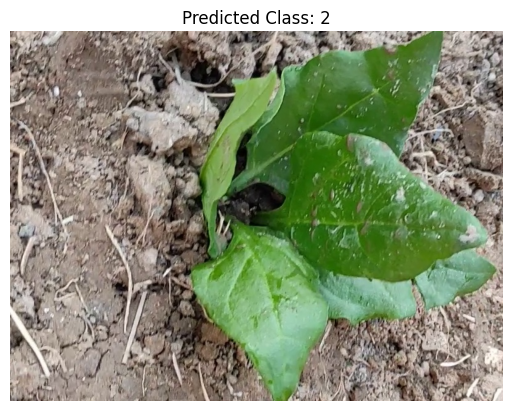

In [ ]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/espinaca_00408.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

Otra manera de hacer la prueba

In [ ]:
# Cargar el modelo y el optimizador desde el checkpoint

# Cargar la imagen para prueba
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch
    return image

# Realizar una prueba con una imagen cargada
def predict(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item()

# Ejemplo de uso
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Reemplaza con la ruta a tu imagen
predicted_class = predict(image_path)
print(f'Predicted class: {predicted_class}')


Predicted class: 0
